In [3]:
!pip install pillow numpy torch opencv-python matplotlib seaborn torchvision tqdm scikit-learn umap-learn huggingface-hub git-lfs transformers timm einops

In [4]:
import torch
import cv2
import os
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
from tqdm import tqdm
import numpy as np
from transformers import pipeline
from huggingface_hub import hf_hub_url, cached_download
from torch.nn import MultiheadAttention
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
import numpy as np
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torch.nn import MultiheadAttention

REPO_NAME = 'ppxscal/cv_project'
X_FILE = 'X_tensor.pt'
Y_FILE = 'y_tensor.pt'

# Get the URL for each file
x_url = hf_hub_url(REPO_NAME, X_FILE)
y_url = hf_hub_url(REPO_NAME, Y_FILE)

# Download the files and cache them locally
x_cache = cached_download(x_url)
y_cache = cached_download(y_url)

# Load the tensors from the cached files
X = torch.load(x_cache)
y = torch.load(y_cache)

In [5]:
import torch
import torch.fft

# Assuming X is loaded and has shape [8831, 128, 128]

# Compute the Fourier transform
X_fft = torch.fft.fft2(torch.tensor(X, dtype=torch.complex64), dim=(-2, -1))

# Shift the zero-frequency component to the center
X_fft_shifted = torch.fft.fftshift(X_fft, dim=(-2, -1))

# Take the magnitude (you could also take the phase or real/imaginary parts depending on your need)
X_fft_mag = X_fft_shifted.abs()

# Normalize the magnitude for better visualization and learning stability
X_fft_mag = (X_fft_mag - X_fft_mag.min()) / (X_fft_mag.max() - X_fft_mag.min())

# Add a channel dimension to original and FFT images
X_original = X.unsqueeze(1)  # Shape becomes [8831, 1, 128, 128]
X_fft_mag = X_fft_mag.unsqueeze(1)  # Shape becomes [8831, 1, 128, 128]

# Concatenate along the channel dimension
X_combined = torch.cat((X_original, X_fft_mag), dim=1)  # Shape becomes [8831, 2, 128, 128]

/var/folders/xl/r4___wpd4psfv7ckxk9gm2m00000gn/T/ipykernel_98346/132908969.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_fft = torch.fft.fft2(torch.tensor(X, dtype=torch.complex64), dim=(-2, -1))


In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        # Adjust the first convolutional layer to accept 2 channels
        self.conv1 = nn.Conv2d(2, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        # Adjust the size of the flattened layer accordingly if the input size changes
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 4)  # Assuming 4 classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 16 * 16)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Device configuration, optimizer, loss function, and training loop remain the same.
    
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")  

print(f'Using device: {device}')

model = Model().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

num_epochs = 15  # You can adjust this based on your specific needs

from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_combined, y, test_size=0.35, random_state=42)

# Create DataLoaders for both training and validation sets
print('X_train:', X_train.shape, 'y_train:', y_train.shape)
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs.data, 1)
    total = labels.size(0)
    correct = (predicted == labels).sum().item()
    return 100 * correct / total

# Starting the training and validation process
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    for images, labels in tqdm(train_loader):  # Use train_loader for training
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f'Epoch {epoch + 1}, Training Loss: {running_loss / len(train_loader)}')
    
    # Validation phase
    model.eval()  # Set the model to evaluation mode
    val_running_loss = 0.0
    val_accuracy = 0.0
    with torch.no_grad():  # No gradient updates during validation
        for images, labels in tqdm(val_loader):  # Use val_loader for validation
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            val_accuracy += calculate_accuracy(outputs, labels)
    
    avg_val_loss = val_running_loss / len(val_loader)
    avg_val_accuracy = val_accuracy / len(val_loader)
    print(f'Epoch {epoch + 1}, Validation Loss: {avg_val_loss}, Validation Accuracy: {avg_val_accuracy}% \n')

Using device: mps
X_train: torch.Size([5740, 2, 128, 128]) y_train: torch.Size([5740])


100%|██████████| 180/180 [00:11<00:00, 15.53it/s]


Epoch 1, Training Loss: 1.0297284480598239


100%|██████████| 97/97 [00:01<00:00, 50.86it/s]


Epoch 1, Validation Loss: 0.9534296135312503, Validation Accuracy: 52.05507325013564% 



100%|██████████| 180/180 [00:10<00:00, 16.57it/s]


Epoch 2, Training Loss: 0.9407210701041752


100%|██████████| 97/97 [00:01<00:00, 63.45it/s]


Epoch 2, Validation Loss: 0.8970602799936668, Validation Accuracy: 58.230466630493765% 



100%|██████████| 180/180 [00:14<00:00, 12.43it/s]


Epoch 3, Training Loss: 0.8570252597332001


100%|██████████| 97/97 [00:02<00:00, 37.65it/s]


Epoch 3, Validation Loss: 0.7950034282871128, Validation Accuracy: 64.02095767769941% 



100%|██████████| 180/180 [00:12<00:00, 14.27it/s]


Epoch 4, Training Loss: 0.7415237847301696


100%|██████████| 97/97 [00:01<00:00, 59.46it/s]


Epoch 4, Validation Loss: 0.6871528564040194, Validation Accuracy: 67.83267769940315% 



100%|██████████| 180/180 [00:11<00:00, 15.04it/s]


Epoch 5, Training Loss: 0.6104044010241826


100%|██████████| 97/97 [00:01<00:00, 57.28it/s]


Epoch 5, Validation Loss: 0.5696457904024222, Validation Accuracy: 76.45822029300054% 



100%|██████████| 180/180 [00:12<00:00, 14.94it/s]


Epoch 6, Training Loss: 0.4256326023903158


100%|██████████| 97/97 [00:01<00:00, 55.30it/s]


Epoch 6, Validation Loss: 0.5378318564179018, Validation Accuracy: 76.37174443841563% 



100%|██████████| 180/180 [00:11<00:00, 15.71it/s]


Epoch 7, Training Loss: 0.30034282116426364


100%|██████████| 97/97 [00:01<00:00, 57.03it/s]


Epoch 7, Validation Loss: 0.33527330416686757, Validation Accuracy: 87.63734400434076% 



100%|██████████| 180/180 [00:11<00:00, 15.73it/s]


Epoch 8, Training Loss: 0.20664021513528294


100%|██████████| 97/97 [00:01<00:00, 58.93it/s]


Epoch 8, Validation Loss: 0.2833059919402771, Validation Accuracy: 90.36557243624526% 



100%|██████████| 180/180 [00:12<00:00, 14.27it/s]


Epoch 9, Training Loss: 0.12043821271508932


100%|██████████| 97/97 [00:01<00:00, 58.85it/s]


Epoch 9, Validation Loss: 0.23322501179483748, Validation Accuracy: 92.34095225176344% 



100%|██████████| 180/180 [00:11<00:00, 15.79it/s]


Epoch 10, Training Loss: 0.0764513675045843


100%|██████████| 97/97 [00:01<00:00, 60.13it/s]


Epoch 10, Validation Loss: 0.20817923052332452, Validation Accuracy: 93.56687466087901% 



100%|██████████| 180/180 [00:10<00:00, 17.02it/s]


Epoch 11, Training Loss: 0.052220436239925526


100%|██████████| 97/97 [00:01<00:00, 53.79it/s]


Epoch 11, Validation Loss: 0.1668342304387197, Validation Accuracy: 94.91996744438416% 



100%|██████████| 180/180 [00:10<00:00, 17.34it/s]


Epoch 12, Training Loss: 0.04102274446373081


100%|██████████| 97/97 [00:01<00:00, 62.28it/s]


Epoch 12, Validation Loss: 0.14405173721924885, Validation Accuracy: 95.3709983722192% 



100%|██████████| 180/180 [00:10<00:00, 16.92it/s]


Epoch 13, Training Loss: 0.035396131948154004


100%|██████████| 97/97 [00:01<00:00, 55.51it/s]


Epoch 13, Validation Loss: 0.11623934616776395, Validation Accuracy: 97.01403960933261% 



100%|██████████| 180/180 [00:11<00:00, 15.96it/s]


Epoch 14, Training Loss: 0.016647539065969694


100%|██████████| 97/97 [00:02<00:00, 44.43it/s]


Epoch 14, Validation Loss: 0.14761506368828572, Validation Accuracy: 96.52061855670104% 



100%|██████████| 180/180 [00:10<00:00, 17.49it/s]


Epoch 15, Training Loss: 0.018487983371596784


100%|██████████| 97/97 [00:01<00:00, 50.06it/s]

Epoch 15, Validation Loss: 0.11639431291787895, Validation Accuracy: 97.14290558871406% 



8831 (8831, 4) (4,) 8831


/Users/Pascal/opt/anaconda3/envs/mit6300/lib/python3.12/site-packages/umap/umap_.py:1880: UserWarning: gradient function is not yet implemented for hamming distance metric; inverse_transform will be unavailable
  warn(


(8831, 2)


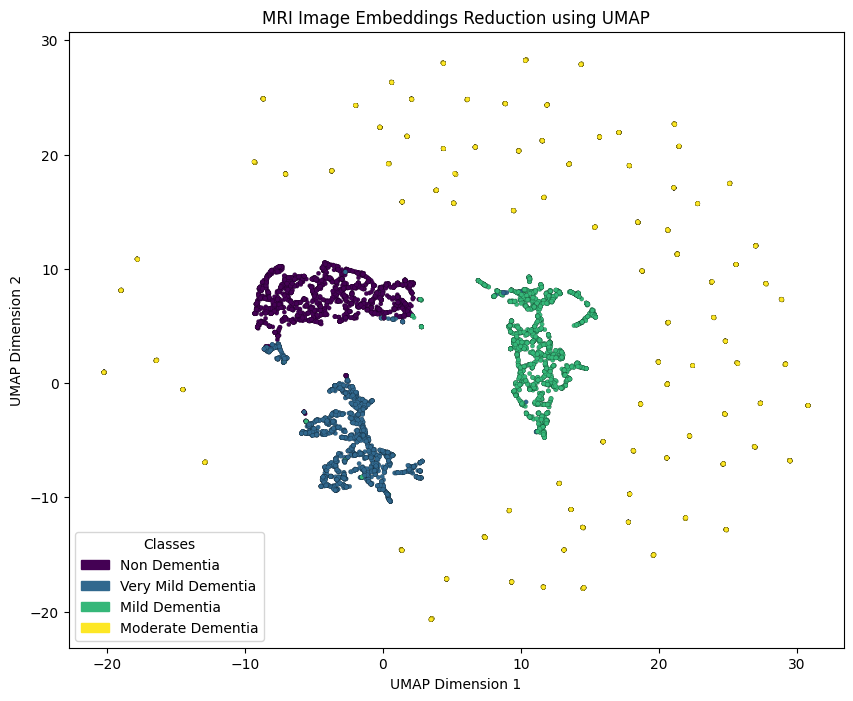

In [15]:
model.eval()
embeddings = []
labels_list = []

class_counts = y.bincount()
num_samples = y.size(0)
class_weights = 1. / class_counts

# Create a list of weights for each sample
sample_weights = class_weights[y]

# Set up the sampler
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=num_samples, replacement=True)

# Create a dataset and a dataloader
dataset = TensorDataset(X_combined, y)
dataloader = DataLoader(dataset, batch_size=32, sampler=sampler)
# dataloader = DataLoader(dataset, batch_size=32)
# dataloader = train_loader
with torch.no_grad():
    for images, labels in dataloader:
        images = images.to(device)
        emb = model(images)
        # print(F.softmax(emb, dim=0))
        embeddings.append(emb.cpu().numpy())
        labels_list.append(labels.cpu().numpy())

# Concatenate all embeddings and labels
embeddings = np.concatenate(embeddings, axis=0)
labels_list = np.concatenate(labels_list, axis=0)

import numpy as np
import umap
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from matplotlib.cm import plasma  # Import plasma colormap

labels_to_class = {
0: "Non Dementia",
1: "Very Mild Dementia",
2: "Mild Dementia",
3: "Moderate Dementia",
}
print(len(embeddings), embeddings.shape, embeddings[0].shape, len(labels_list))

# Perform UMAP reduction
reducer = umap.UMAP(n_neighbors=10, min_dist=0.15, n_components=2, metric='hamming')
umap_embeddings = reducer.fit_transform(embeddings)
print(umap_embeddings.shape)
# umap_embeddings = umap_embeddings / np.linalg.norm(umap_embeddings, axis=1)
cmap = plt.cm.viridis

plt.figure(figsize=(10, 8))
scatter = plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=labels_list, cmap=cmap, s=10, edgecolor='black', linewidth=0.1)
# Create a legend
legend_handles = [mpatches.Patch(color=cmap(i / (len(labels_to_class) - 1)), label=labels_to_class[i]) for i in labels_to_class]
plt.legend(handles=legend_handles, title="Classes")

plt.title('MRI Image Embeddings Reduction using UMAP')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()